In [159]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
from scipy import ndimage as ndi
from scipy.spatial import procrustes
from scipy.spatial.transform import Rotation as R
import cv2
import SimpleITK as sitk
import ipywidgets
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
pv.set_jupyter_backend("panel")

In [2]:
%load_ext autoreload
%autoreload 2

In [89]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, \
    affine_transform_point, resample_image, load_transformation, get_min_max_mean, \
    create_subvolume_from_boundary_vertices

from library.controller.sql_controller import SqlController


/home/eddyod/programming/pipeline/src


In [4]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()

def get_clockwise_edge_coords(array):
    # Ensure the array is binary (non-zero becomes 1)
    binary = (array > 0).astype(np.uint8)
    
    # Use skimage's find_contours to detect contours at level 0.5
    contours = measure.find_contours(binary, 0.5)

    # If multiple contours, take the largest (most points)
    if not contours:
        return []
    contour = max(contours, key=len)

    # Convert (row, col) to (x, y) and round to int
    coords = np.fliplr(contour).astype(int)

    # Ensure clockwise order using signed area (shoelace formula)
    def is_clockwise(pts):
        return np.sum(
            (pts[1:, 0] - pts[:-1, 0]) * (pts[1:, 1] + pts[:-1, 1])
        ) > 0

    if not is_clockwise(coords):
        coords = coords[::-1]  # Reverse if not clockwise

    return coords


def get_evenly_spaced_vertices(mask, num_points):
    """
    Given a binary mask, extract the outer contour and return evenly spaced vertices along the edge.

    Parameters:
    - mask: 2D numpy array (binary mask)
    - num_points: Number of evenly spaced points to return

    Returns:
    - List of (x, y) coordinates of vertices
    """
    # Ensure mask is uint8
    mask = mask.astype(np.uint8)

    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return []

    # Choose the largest contour (in case there are multiple)
    contour = max(contours, key=cv2.contourArea).squeeze()

    # Calculate arc length (perimeter)
    arc_length = cv2.arcLength(contour, True)
    print(arc_length)

    # Calculate the cumulative arc lengths
    distances = [0]
    for i in range(1, len(contour)):
        d = np.linalg.norm(contour[i] - contour[i - 1])
        distances.append(distances[-1] + d)
    distances = np.array(distances)

    # Sample points at regular intervals
    desired_distances = np.linspace(0, distances[-1], num_points, endpoint=False)
    vertices = []
    j = 0
    for d in desired_distances:
        while j < len(distances) - 1 and distances[j+1] < d:
            j += 1
        # Linear interpolation between points j and j+1
        t = (d - distances[j]) / (distances[j+1] - distances[j])
        pt = (1 - t) * contour[j] + t * contour[j + 1]
        vertices.append(tuple(pt.astype(int)))

    return vertices



In [160]:
def center_images_to_largest_volume(images):
    """
    Centers a list of 3D SimpleITK images using the largest-volume image as the reference.

    Parameters:
        images (List[sitk.Image]): List of 3D SimpleITK Image objects.

    Returns:
        List[sitk.Image]: List of centered images (same order as input).
    """
    if not images:
        raise ValueError("No images provided.")

    # Compute volumes and find reference image
    volumes = [img.GetSize()[0] * img.GetSize()[1] * img.GetSize()[2] * 
               img.GetSpacing()[0] * img.GetSpacing()[1] * img.GetSpacing()[2] for img in images]
    reference_index = volumes.index(max(volumes))
    reference_image = images[reference_index]

    """
    ref_center = sitk.PhysicalPointSource(reference_image.GetPixelID(), reference_image.GetSize(), reference_image.GetOrigin(),
                                          reference_image.GetSpacing(), reference_image.GetDirection())
    ref_center = sitk.CenteredTransformInitializer(reference_image, reference_image,
                                                   sitk.Euler3DTransform(), 
                                                   sitk.CenteredTransformInitializerFilter.MOMENTS).GetTranslation()

    """
    centered_images = []
    for i, img in enumerate(images):
        if i == reference_index:
            centered_images.append(img)
            continue

        # Calculate center transform
        transform = sitk.CenteredTransformInitializer(reference_image, img,
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

        # Resample image
        resampled = sitk.Resample(img,
                                  reference_image,
                                  transform,
                                  sitk.sitkLinear,
                                  0.0,
                                  img.GetPixelID())

        centered_images.append(resampled)

    return centered_images


def resize_image(image, new_size):
    """
    Resamples an image to match the reference image in size, spacing, and direction.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)  # Linear interpolation for resampling
    resampler.SetDefaultPixelValue(0)  # Fill with zero if needed
    resultImage = resampler.Execute(image)
    #return sitk.GetArrayFromImage(resultImage)
    return resultImage


def load_volumes(structure):
    images = []

    brains = ['MD585', 'MD589', 'MD594']
    for brain in brains:
        structure_path = os.path.join(data_path, brain, 'structure', f'{structure}.npy')
        arr = np.load(structure_path)
        arr = arr.astype(np.float32)
        print(arr.dtype, arr.shape)
        arr = sitk.GetImageFromArray(arr, isVector=False)
        images.append(arr)

    sizes = [img.GetSize() for img in images]
    max_size = np.max(sizes, axis=0)
        
    resampled_images = [resize_image(img, max_size.tolist()) for img in images]
    reference_image = max(resampled_images, key=lambda img: np.prod(img.GetSize()))
    resampled_images = center_images_to_largest_volume(resampled_images)
    resampled_images = align_images_to_common_center(resampled_images)
    
    return resampled_images
        #return [sitk.ReadImage(p, sitk.sitkFloat32) for p in volume_paths]

def get_image_center(image):
    """Compute the physical center of a SimpleITK image."""
    size = np.array(image.GetSize())
    spacing = np.array(image.GetSpacing())
    origin = np.array(image.GetOrigin())
    direction = np.array(image.GetDirection()).reshape(3, 3)
    
    center_index = (size - 1) / 2.0
    center_physical = origin + direction @ (center_index * spacing)
    
    return center_physical

def compute_translation_transform(from_center, to_center):
    """Create a translation transform that moves from_center to to_center."""
    translation_vector = to_center - from_center
    return sitk.TranslationTransform(3, translation_vector)

def align_images_to_common_center(images):
    """
    Given a list of SimpleITK 3D images, return a list of translated images
    aligned to their common center.
    """
    centers = [get_image_center(img) for img in images]
    common_center = np.mean(centers, axis=0)
    print('common center via mean', common_center)
    

    aligned_images = []

    for img, center in zip(images, centers):
        transform = compute_translation_transform(center, common_center)
        resampled = sitk.Resample(
            img,
            img.GetSize(),
            transform,
            sitk.sitkLinear,
            img.GetOrigin(),
            img.GetSpacing(),
            img.GetDirection(),
            0.0,  # default pixel value
            img.GetPixelID()
        )
        aligned_images.append(resampled)
    
    return aligned_images

def make_subvolume_from_points(
    points_xyz,
    volume_shape_zyx,
    method="morph",       # 'points' | 'bbox' | 'morph'
    radius=2,             # radius for morphological growth (voxels)
    fill=True,            # fill internal voids after growth
    on_value=255,
    dtype=np.uint8
):
    """
    Create a 3D volume (Z,Y,X) where voxels inside the region defined by sparse
    (x,y,z) points are set to `on_value` and others to 0.

    Parameters
    ----------
    points_xyz : array-like of shape (N,3)
        Sparse coordinates given as (x, y, z) in voxel units.
    volume_shape_zyx : tuple (Z, Y, X)
        Output volume shape.
    method : str
        'points' -> mark only the given points.
        'bbox'   -> fill the axis-aligned bounding box of the points.
        'morph'  -> grow points with binary dilation/closing and (optionally) fill holes (default).
    radius : int
        Morphological growth radius (used when method='morph').
    fill : bool
        If True, perform 3D hole filling after growth (method='morph').
    on_value : int
        Intensity set inside the region (default 255).
    dtype : numpy dtype
        Output dtype.

    Returns
    -------
    vol : ndarray (Z, Y, X), dtype=dtype
    """
    vol = np.zeros(volume_shape_zyx, dtype=dtype)
    pts = np.asarray(points_xyz, dtype=np.int64)

    if pts.ndim != 2 or pts.shape[1] != 3:
        raise ValueError("points_xyz must have shape (N, 3) as (x, y, z)")

    # Convert (x,y,z) -> (z,y,x) for indexing a (Z,Y,X) array
    pts_zyx = pts[:, [2, 1, 0]]

    # Clip to bounds
    Z, Y, X = volume_shape_zyx
    in_bounds = (
        (pts_zyx[:, 0] >= 0) & (pts_zyx[:, 0] < Z) &
        (pts_zyx[:, 1] >= 0) & (pts_zyx[:, 1] < Y) &
        (pts_zyx[:, 2] >= 0) & (pts_zyx[:, 2] < X)
    )
    pts_zyx = pts_zyx[in_bounds]
    if pts_zyx.size == 0:
        return vol  # nothing to draw

    # Seed mask at given points
    mask = np.zeros(volume_shape_zyx, dtype=bool)
    mask[pts_zyx[:, 0], pts_zyx[:, 1], pts_zyx[:, 2]] = True

    if method == "points":
        return np.where(mask, on_value, 0).astype(dtype)

    if method == "bbox":
        z0, y0, x0 = pts_zyx.min(axis=0)
        z1, y1, x1 = pts_zyx.max(axis=0) + 1  # slice end is exclusive
        vol[z0:z1, y0:y1, x0:x1] = on_value
        return vol

    if method == "morph":
        # create a 3D connectivity structure (6-connectivity by default)
        structure = ndi.generate_binary_structure(rank=3, connectivity=1)

        # Dilate to thicken sparse points
        if radius > 0:
            mask = ndi.binary_dilation(mask, structure=structure, iterations=radius)

        # A light closing helps bridge small gaps
        if radius > 1:
            mask = ndi.binary_closing(mask, structure=structure, iterations=max(1, radius // 2))

        # Optionally fill internal voids (3D)
        if fill:
            mask = ndi.binary_fill_holes(mask)

        return np.where(mask, on_value, 0).astype(dtype)

    raise ValueError("Unknown method. Use 'points', 'bbox', or 'morph'.")


def _scipy_affine_from_homogeneous(M4x4):
    """
    Convert a 4x4 homogeneous transform (maps input->output in world coords)
    into (matrix, offset) for scipy.ndimage.affine_transform, which expects
    a mapping from output coords to input coords.

    For input x_in and output x_out:
      x_out = A @ x_in + t
    SciPy needs x_in = A_inv @ x_out + (-A_inv @ t)
    """
    M = np.asarray(M4x4, dtype=float)
    if M.shape != (4, 4):
        raise ValueError("Affine must be 4x4 homogeneous matrix")

    A = M[:3, :3]
    t = M[:3, 3]
    A_inv = np.linalg.inv(A)
    offset = -A_inv @ t
    return A_inv, offset


def apply_affine_3d(
    vol_zyx,
    M4x4,
    output_shape=None,
    order=0,        # 0 keeps labels (0/255) crisp
    mode="constant",
    cval=0.0,
    prefilter=False
):
    """
    Apply a 4x4 affine transform to a 3D volume using scipy.ndimage.affine_transform.

    Parameters
    ----------
    vol_zyx : ndarray (Z, Y, X)
        Input volume (e.g., 0/255).
    M4x4 : ndarray (4,4)
        Homogeneous transform matrix. Convention: columns [R|t].
    output_shape : tuple or None
        Shape of output volume (Z, Y, X). If None, uses input shape.
    order : int
        Interpolation order (0..5). Use 0 for label images (binary/255).
    mode : str
        Boundary mode for samples outside input.
    cval : float
        Constant fill value for 'constant' mode.
    prefilter : bool
        Keep False when order=0 for speed and to avoid unwanted smoothing.

    Returns
    -------
    out : ndarray
        Transformed volume.
    """
    if output_shape is None:
        output_shape = vol_zyx.shape

    matrix, offset = _scipy_affine_from_homogeneous(M4x4)
    out = ndi.affine_transform(
        vol_zyx,
        matrix=matrix,
        offset=offset,
        output_shape=output_shape,
        order=order,
        mode=mode,
        cval=cval,
        prefilter=prefilter
    )
    # If order=0, values will already be 0 or 255. For safety, cast back to original dtype.
    return out.astype(vol_zyx.dtype)


In [ ]:
structure = 'cerebellum'

In [ ]:
#aligned_volumes, final_average = groupwise_register_and_align()
aligned_volumes = load_volumes(structure)

In [ ]:
avg_volume = np.mean([sitk.GetArrayFromImage(vol) for vol in aligned_volumes], axis=0)
print(avg_volume.dtype, avg_volume.shape)

In [ ]:
allen_id = 255
arr = avg_volume.copy()
z = arr.shape[1] // 2
print('midpoint=',z)
volume = arr.copy()
#volume = adjust_volume(volume, 255)
volume = gaussian(volume, 4.0)            
upper = np.quantile(volume, 0.8)
print('upper', upper)
upper = 100
print(np.mean(volume), np.min(volume), np.max(volume))
volume[(volume > upper) ] = allen_id
volume[(volume != allen_id)] = 0
volume = volume.astype(np.uint32)

slice = volume[:,z,:]
plt.imshow(slice, cmap='gray')

In [ ]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
for brain in brains:
    structure_path = os.path.join(data_path, brain, 'structure', f'{structure}.npy')
    arr = np.load(structure_path)
    #affine = convert_euler(brain)
    #arr = affine_transform_volume(arr, affine)
    volumes.append(arr)
    com = center_of_mass(arr)
    print(f'{brain} {arr.dtype} {arr.shape} {np.round(com)}')


_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(volumes, axs, brains):
    z = img.shape[1] // 8
    slice = img[:,z,:].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 250)
    ax.imshow(slice, cmap="gray")
plt.show()

In [ ]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
for brain in brains:
    structure_path = os.path.join(data_path, brain, 'structure2allen', f'{structure}.npy')
    arr = np.load(structure_path)
    volumes.append(arr)
    com = center_of_mass(arr)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')

_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(volumes, axs, brains):
    z = img.shape[2] // 2
    slice = img[:,:,z].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 320)
    ax.imshow(slice, cmap="gray")
plt.show()

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(aligned_volumes, axs, brains):
    img = sitk.GetArrayFromImage(img)
    com = center_of_mass(img)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')
    z = img.shape[2] // 2
    slice = img[:,:,z].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 210)
    ax.set_ylim(0,230)
    ax.imshow(slice, cmap="gray")
plt.show()

In [ ]:
volumes = []
for volume in registered_images:
    arr = sitk.GetArrayFromImage(volume)
    com = center_of_mass(arr)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')
    volumes.append(arr)
_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(volumes, axs, brains):
    z = img.shape[2] // 2
    slice = img[:,:,-10].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 200)
    ax.set_ylim(0,230)
    ax.imshow(slice, cmap="gray")
plt.show()

In [ ]:
animal = 'ALLEN771602'
structure = 'cerebellum'
structure_path = os.path.join(data_path, animal, 'structure', f'{structure}.npy')
arr = np.load(structure_path)
ids, counts = np.unique(arr, return_counts=True)
if len(ids) < 10:
    print(ids)
    print(counts)
print(arr.shape, arr.dtype, np.mean(arr), np.min(arr), np.max(arr))

In [ ]:
allen_id = 200
volume = gaussian(arr, 4)
#volume = arr.copy()
upper = 100

mean = np.mean(volume)
print(mean, np.min(volume), np.max(volume))
volume[(volume >= mean) ] = allen_id
volume[(volume < mean)] = 0
#volume = volume.astype(np.uint8)
#hist_data = arr[arr > 0]
plt.hist(volume.flatten(), bins=30, color='skyblue', alpha=0.7)
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'{structure} Histogram')
# Show the plot
plt.show()

In [ ]:
z = arr.shape[2] // 2
volume = arr.copy()
volume = adjust_volume(volume, 255)
slice = volume[:,:,z].astype(np.uint32)
plt.imshow(slice, cmap='gray')

In [ ]:
adjusted = adjust_volume(volume, 255)
slice = adjusted[:,:,z].astype(np.uint32)
plt.imshow(slice, cmap='gray')

In [ ]:
#n, nl, vertices = get_outer_edge_vertices(slice)
vertices = get_evenly_spaced_vertices(slice, 20)
# Visualize result
plt.imshow(slice, cmap='gray')
x, y = zip(*vertices)
plt.plot(x, y, 'r-')
plt.scatter(x, y, c='blue')
plt.title("Contour Vertices")
plt.show()

In [ ]:
slice = volume[:,:,z].astype(np.uint32)
print(volume.shape)

In [ ]:
data = pv.wrap(vol)
data.plot(volume=True) # Volume render

In [40]:
filepath = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/cerebellum.npy'
vol = np.load(filepath)
ids, counts = np.unique(vol, return_counts=True)
print(vol.shape, vol.dtype, ids, counts)
#visualize_slices(vol, title="Transformed Volume")

(425, 558, 776) uint8 [  0 255] [89883393 94145007]


In [ ]:
# Visualize original and transformed volumes
transformed_volume = affine_transform_volume(volume, transformation_matrix)
visualize_slices(transformed_volume, title="Transformed Volume")

In [149]:
animal = 'ALLEN771602'
sqlController = SqlController(animal)
transform = load_transformation(animal, 10.0, 10.0, inverse=False)

In [168]:
xyz_array = sqlController.get_annotation_xyz_array(8357, 10)
min_vals = np.min(polygons, axis=0)
max_vals = np.max(polygons, axis=0)

In [170]:
# Create a subvolume in a 3D array of shape (Z=32, Y=64, X=64)
vol = make_subvolume_from_points(
    xyz_array,
    volume_shape_zyx=(27, 482, 447),
    method="morph",   # robust for sparse, possibly non-convex sets
    radius=12,
    fill=True,
    on_value=255,
    dtype=np.uint8
)

In [171]:
ids, counts = np.unique(vol, return_counts=True)
print(ids)
print(counts)

[0]
[5817258]


In [172]:
polygons = sqlController.get_annotation_volume(8357, 10)
coords = list(polygons.values())
min_vals, max_vals, mean_vals = get_min_max_mean(coords)

In [134]:
min_x = min_vals[0]
min_y = min_vals[1]
max_x = max_vals[0]
max_y = max_vals[1]
xlength = max_x - min_x
ylength = max_y - min_y
slice_size = (int(round(ylength)), int(round(xlength)))
print(f'slice size={slice_size} {min_x=} {min_y=} {max_x=} {max_y=}')
print(f'Pre transformation array with shape {xyz_array.shape}')
print(f'min={np.min(xyz_array, axis=0)} max={np.max(xyz_array, axis=0)} dtype={xyz_array.dtype}')

slice size=(482, 447) min_x=1113.3361607789993 min_y=64.1660240944475 max_x=1560.6903471052647 max_y=545.927369967103
Pre transformation array with shape (597, 3)
min=[1113.33616078   64.16602409  297.10000381] max=[1560.69034711  545.92736997 1187.70003319] dtype=float64


In [173]:
slices = []
sections = {}
# You need to subtract the min_x and min_y from the points as the volume is only as big as the range of x and y
for section, points in sorted(polygons.items()):
    sections[section] = len(points)
    vertices = np.array(points) - np.array((min_x, min_y))
    volume_slice = np.zeros(slice_size, dtype=np.uint8)
    points = (vertices).astype(np.int32)
    cv2.polylines(volume_slice, [points], isClosed=True, color=255, thickness=10)
    cv2.fillPoly(volume_slice, pts=[points], color=255)
    slices.append(volume_slice)

volume = np.stack(slices, axis=0).astype(np.uint8)  # Keep this at uint8!
#volume = np.swapaxes(volume, 0,2)
print('shape', volume.shape)
print('sorted sections', len(sections))
print(volume.shape)
#visualize_slices(volume, title="Original Volume")
# @10um section min=297, max=1187

shape (27, 482, 447)
sorted sections 27
(27, 482, 447)


In [156]:
M = np.array(transform.GetParameters()[:9]).reshape(3,3)
print(M)
t = (0,0,0)
transformed_volume = affine_transform(volume, M, t, order=3)
print(transformed_volume.shape, transformed_volume.dtype)
transformed_volume[transformed_volume > 0] = 255
ids, counts = np.unique(transformed_volume, return_counts=True)
print(ids)
print(counts)

[[ 1.04464403  0.10560038  0.02444315]
 [-0.05295399  0.83190037 -0.03976969]
 [-0.03106221  0.0322132   1.15467075]]
(27, 482, 447) uint8
[  0 255]
[5553303  263955]


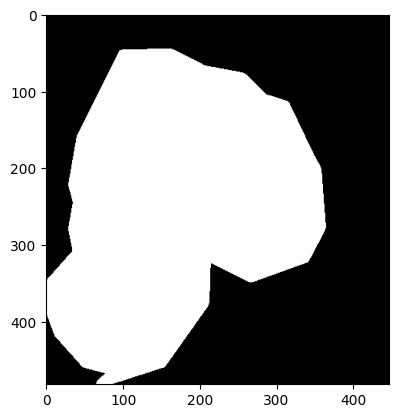

In [174]:
slice = volume[10,:,:]
plt.imshow(slice, cmap='gray')

In [94]:
ids, counts = np.unique(xyz_array, return_counts=True)
print('ids', ids)
print('counts', counts)

ids [  64.16602409   67.68796593   67.88428873 ... 1558.84604901 1559.44405124
 1560.69034711]
counts [1 1 1 ... 1 1 1]


In [80]:
transformed_list = [transform.TransformPoint(point) for point in xyz_array]
xyz_array = np.array(transformed_list)
print(f'Post transformation array with shape {xyz_array.shape}')
print(f'min={np.min(xyz_array, axis=0)} max={np.max(xyz_array, axis=0)} dtype={xyz_array.dtype}')

Post transformation array with shape (597, 3)
min=[959.71686695  95.8869554  195.3326652 ] max=[1383.76870921  652.84985134  970.06324439] dtype=float64


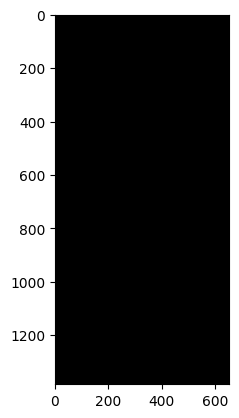